# <font color='red'>COMPUTER VISION WITH DEEP LEARNING</font>

# <font color='blue'>Pix2Pix with Generative AI (GAN)</font>

### <font color='green'>1. Set up required libraries</font>

In [1]:
!pip install tqdm

In [2]:
import os
import glob
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm

### <font color='green'>2. Define Dataset for Pix2Pix (Edges2Shoes)</font>

In [3]:
class Pix2PixDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, "*.jpg")))
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        w, h = img.size
        # Giả sử ảnh là ghép đôi ngang: bên trái edge, bên phải shoe
        w2 = int(w / 2)
        edge = img.crop((0, 0, w2, h))
        shoe = img.crop((w2, 0, w, h))
        if self.transform:
            edge = self.transform(edge)
            shoe = self.transform(shoe)
        return edge, shoe

transform_fn = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dir = "/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/train"
val_dir = "/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val"

train_dataset = Pix2PixDataset(train_dir, transform=transform_fn)
val_dataset = Pix2PixDataset(val_dir, transform=transform_fn)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)


### <font color='green'>3. Define U-net Structure for Generator and Discriminator</font>

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, ngf=64):
        super(Generator, self).__init__()
        self.down1 = nn.Sequential(nn.Conv2d(in_channels, ngf, 4, 2, 1), nn.LeakyReLU(0.2, True))
        self.down2 = nn.Sequential(nn.Conv2d(ngf, ngf*2, 4, 2, 1), nn.BatchNorm2d(ngf*2), nn.LeakyReLU(0.2, True))
        self.down3 = nn.Sequential(nn.Conv2d(ngf*2, ngf*4, 4, 2, 1), nn.BatchNorm2d(ngf*4), nn.LeakyReLU(0.2, True))
        self.down4 = nn.Sequential(nn.Conv2d(ngf*4, ngf*8, 4, 2, 1), nn.BatchNorm2d(ngf*8), nn.LeakyReLU(0.2, True))
        self.bottleneck = nn.Sequential(nn.Conv2d(ngf*8, ngf*8, 4, 2, 1), nn.ReLU(True))
        self.up1 = nn.Sequential(nn.ConvTranspose2d(ngf*8, ngf*8, 4, 2, 1), nn.BatchNorm2d(ngf*8), nn.ReLU(True))
        self.up2 = nn.Sequential(nn.ConvTranspose2d(ngf*8*2, ngf*4, 4, 2, 1), nn.BatchNorm2d(ngf*4), nn.ReLU(True))
        self.up3 = nn.Sequential(nn.ConvTranspose2d(ngf*4*2, ngf*2, 4, 2, 1), nn.BatchNorm2d(ngf*2), nn.ReLU(True))
        self.up4 = nn.Sequential(nn.ConvTranspose2d(ngf*2*2, ngf, 4, 2, 1), nn.BatchNorm2d(ngf), nn.ReLU(True))
        self.final = nn.Sequential(nn.ConvTranspose2d(ngf*2, out_channels, 4, 2, 1), nn.Tanh())
        
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        bn = self.bottleneck(d4)
        up1 = self.up1(bn)
        up1 = torch.cat([up1, d4], 1)
        up2 = self.up2(up1)
        up2 = torch.cat([up2, d3], 1)
        up3 = self.up3(up2)
        up3 = torch.cat([up3, d2], 1)
        up4 = self.up4(up3)
        up4 = torch.cat([up4, d1], 1)
        out = self.final(up4)
        return out

class Discriminator(nn.Module):
    def __init__(self, in_channels=6, ndf=64):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels, ndf, 4, 2, 1), nn.LeakyReLU(0.2, True))
        self.layer2 = nn.Sequential(nn.Conv2d(ndf, ndf*2, 4, 2, 1), nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2, True))
        self.layer3 = nn.Sequential(nn.Conv2d(ndf*2, ndf*4, 4, 2, 1), nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2, True))
        self.layer4 = nn.Sequential(nn.Conv2d(ndf*4, ndf*8, 4, 1, 1), nn.BatchNorm2d(ndf*8), nn.LeakyReLU(0.2, True))
        self.final = nn.Conv2d(ndf*8, 1, 4, 1, 1)
        
    def forward(self, x, y):
        inp = torch.cat([x, y], 1)
        l1 = self.layer1(inp)
        l2 = self.layer2(l1)
        l3 = self.layer3(l2)
        l4 = self.layer4(l3)
        out = self.final(l4)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator().to(device)
netD = Discriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)


Discriminator(
  (layer1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (final): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

### <font color='green'>4. Define Loss, Optimizer and Training Loop</font>

In [8]:
from torch.utils.data import Subset
from tqdm import tqdm
import torch.cuda.amp as amp

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()

optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=10, gamma=0.5)
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=10, gamma=0.5)

num_epochs = 50
lambda_L1 = 100

num_samples = 4000
indices = random.sample(range(len(train_dataset)), num_samples)
debug_dataset = Subset(train_dataset, indices)
debug_loader = DataLoader(debug_dataset, batch_size=4, shuffle=True, num_workers=2)

scaler = amp.GradScaler()

for epoch in range(num_epochs):
    progress_bar = tqdm(debug_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, (edge, shoe) in enumerate(progress_bar):
        edge, shoe = edge.to(device), shoe.to(device)
        real_label = torch.ones(edge.size(0), 1, 30, 30, device=device)
        fake_label = torch.zeros(edge.size(0), 1, 30, 30, device=device)
        
        optimizerG.zero_grad()
        with amp.autocast():
            fake_shoe = netG(edge)
            pred_fake = netD(edge, fake_shoe)
            loss_GAN = criterion_GAN(pred_fake, real_label)
            loss_L1 = criterion_L1(fake_shoe, shoe)
            loss_G = loss_GAN + lambda_L1 * loss_L1
        scaler.scale(loss_G).backward()
        scaler.step(optimizerG)
        
        optimizerD.zero_grad()
        with amp.autocast():
            pred_real = netD(edge, shoe)
            loss_D_real = criterion_GAN(pred_real, real_label)
            pred_fake = netD(edge, fake_shoe.detach())
            loss_D_fake = criterion_GAN(pred_fake, fake_label)
            loss_D = 0.5 * (loss_D_real + loss_D_fake)
        scaler.scale(loss_D).backward()
        scaler.step(optimizerD)
        scaler.update()
        
        progress_bar.set_postfix(loss_G=loss_G.item(), loss_D=loss_D.item())
    
    schedulerG.step()
    schedulerD.step()
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss_G: {loss_G.item():.4f} Loss_D: {loss_D.item():.4f}")


<ipython-input-8-b481729d31b1>:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1/50:   0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-8-b481729d31b1>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
<ipython-input-8-b481729d31b1>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Epoch 1/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s, loss_D=0.0171, loss_G=16.7]


Epoch [1/50] Loss_G: 16.6795 Loss_D: 0.0171


Epoch 2/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.57it/s, loss_D=0.444, loss_G=16.9] 


Epoch [2/50] Loss_G: 16.8922 Loss_D: 0.4437


Epoch 3/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.57it/s, loss_D=0.797, loss_G=14.1]


Epoch [3/50] Loss_G: 14.0768 Loss_D: 0.7975


Epoch 4/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.56it/s, loss_D=0.52, loss_G=12.5]  


Epoch [4/50] Loss_G: 12.4532 Loss_D: 0.5201


Epoch 5/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.56it/s, loss_D=0.243, loss_G=17.1]


Epoch [5/50] Loss_G: 17.0827 Loss_D: 0.2434


Epoch 6/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.57it/s, loss_D=0.254, loss_G=9.12]


Epoch [6/50] Loss_G: 9.1186 Loss_D: 0.2537


Epoch 7/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s, loss_D=0.542, loss_G=7.81]


Epoch [7/50] Loss_G: 7.8139 Loss_D: 0.5423


Epoch 8/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s, loss_D=0.513, loss_G=9.22]


Epoch [8/50] Loss_G: 9.2166 Loss_D: 0.5133


Epoch 9/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.57it/s, loss_D=0.224, loss_G=9.42]


Epoch [9/50] Loss_G: 9.4229 Loss_D: 0.2236


Epoch 10/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.57it/s, loss_D=0.288, loss_G=9.44]


Epoch [10/50] Loss_G: 9.4370 Loss_D: 0.2881


Epoch 11/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s, loss_D=0.472, loss_G=9.22]


Epoch [11/50] Loss_G: 9.2184 Loss_D: 0.4720


Epoch 12/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s, loss_D=0.298, loss_G=8.18]


Epoch [12/50] Loss_G: 8.1837 Loss_D: 0.2984


Epoch 13/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s, loss_D=0.191, loss_G=7.52]


Epoch [13/50] Loss_G: 7.5202 Loss_D: 0.1913


Epoch 14/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s, loss_D=0.136, loss_G=9.35]


Epoch [14/50] Loss_G: 9.3517 Loss_D: 0.1364


Epoch 15/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s, loss_D=0.332, loss_G=8.1] 


Epoch [15/50] Loss_G: 8.1042 Loss_D: 0.3316


Epoch 16/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s, loss_D=0.551, loss_G=10.6]


Epoch [16/50] Loss_G: 10.6101 Loss_D: 0.5511


Epoch 17/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s, loss_D=0.318, loss_G=9.02]


Epoch [17/50] Loss_G: 9.0196 Loss_D: 0.3184


Epoch 18/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s, loss_D=0.474, loss_G=7.6] 


Epoch [18/50] Loss_G: 7.6045 Loss_D: 0.4739


Epoch 19/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s, loss_D=0.237, loss_G=7.63]


Epoch [19/50] Loss_G: 7.6269 Loss_D: 0.2374


Epoch 20/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.52it/s, loss_D=0.632, loss_G=5.21]


Epoch [20/50] Loss_G: 5.2088 Loss_D: 0.6322


Epoch 21/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s, loss_D=0.151, loss_G=8.28]


Epoch [21/50] Loss_G: 8.2819 Loss_D: 0.1514


Epoch 22/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s, loss_D=0.126, loss_G=8.68]


Epoch [22/50] Loss_G: 8.6794 Loss_D: 0.1259


Epoch 23/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s, loss_D=0.405, loss_G=6.06]


Epoch [23/50] Loss_G: 6.0599 Loss_D: 0.4048


Epoch 24/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s, loss_D=0.534, loss_G=5.96]


Epoch [24/50] Loss_G: 5.9588 Loss_D: 0.5342


Epoch 25/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s, loss_D=0.68, loss_G=5]   


Epoch [25/50] Loss_G: 5.0013 Loss_D: 0.6805


Epoch 26/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.56it/s, loss_D=0.68, loss_G=6.73] 


Epoch [26/50] Loss_G: 6.7270 Loss_D: 0.6800


Epoch 27/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s, loss_D=0.467, loss_G=6.13]


Epoch [27/50] Loss_G: 6.1342 Loss_D: 0.4667


Epoch 28/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s, loss_D=0.552, loss_G=7.19]


Epoch [28/50] Loss_G: 7.1856 Loss_D: 0.5517


Epoch 29/50: 100%|██████████| 1000/1000 [01:45<00:00,  9.51it/s, loss_D=0.338, loss_G=9.1] 


Epoch [29/50] Loss_G: 9.1020 Loss_D: 0.3380


Epoch 30/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s, loss_D=0.63, loss_G=6.61] 


Epoch [30/50] Loss_G: 6.6117 Loss_D: 0.6299


Epoch 31/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s, loss_D=0.355, loss_G=6.36]


Epoch [31/50] Loss_G: 6.3571 Loss_D: 0.3547


Epoch 32/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s, loss_D=0.41, loss_G=8.14]


Epoch [32/50] Loss_G: 8.1351 Loss_D: 0.4101


Epoch 33/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s, loss_D=0.512, loss_G=6.85]


Epoch [33/50] Loss_G: 6.8527 Loss_D: 0.5118


Epoch 34/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s, loss_D=0.393, loss_G=6.35]


Epoch [34/50] Loss_G: 6.3549 Loss_D: 0.3927


Epoch 35/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s, loss_D=0.274, loss_G=5.81]


Epoch [35/50] Loss_G: 5.8116 Loss_D: 0.2740


Epoch 36/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s, loss_D=0.469, loss_G=6.4]


Epoch [36/50] Loss_G: 6.4039 Loss_D: 0.4691


Epoch 37/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s, loss_D=0.418, loss_G=7.39]


Epoch [37/50] Loss_G: 7.3890 Loss_D: 0.4183


Epoch 38/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s, loss_D=0.854, loss_G=4.05]


Epoch [38/50] Loss_G: 4.0451 Loss_D: 0.8544


Epoch 39/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s, loss_D=0.617, loss_G=6.65]


Epoch [39/50] Loss_G: 6.6535 Loss_D: 0.6172


Epoch 40/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s, loss_D=0.447, loss_G=7.73]


Epoch [40/50] Loss_G: 7.7343 Loss_D: 0.4467


Epoch 41/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s, loss_D=0.568, loss_G=6.44]


Epoch [41/50] Loss_G: 6.4358 Loss_D: 0.5682


Epoch 42/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s, loss_D=0.288, loss_G=5.55]


Epoch [42/50] Loss_G: 5.5471 Loss_D: 0.2884


Epoch 43/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s, loss_D=0.562, loss_G=5.73]


Epoch [43/50] Loss_G: 5.7333 Loss_D: 0.5624


Epoch 44/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s, loss_D=0.804, loss_G=5.52]


Epoch [44/50] Loss_G: 5.5202 Loss_D: 0.8045


Epoch 45/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.56it/s, loss_D=0.476, loss_G=4.4]


Epoch [45/50] Loss_G: 4.3993 Loss_D: 0.4761


Epoch 46/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s, loss_D=0.339, loss_G=5.62]


Epoch [46/50] Loss_G: 5.6234 Loss_D: 0.3389


Epoch 47/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s, loss_D=0.655, loss_G=7.2]


Epoch [47/50] Loss_G: 7.1957 Loss_D: 0.6554


Epoch 48/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s, loss_D=0.443, loss_G=6.22]


Epoch [48/50] Loss_G: 6.2213 Loss_D: 0.4431


Epoch 49/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s, loss_D=0.443, loss_G=7.52]


Epoch [49/50] Loss_G: 7.5183 Loss_D: 0.4428


Epoch 50/50: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s, loss_D=0.476, loss_G=6.43]

Epoch [50/50] Loss_G: 6.4315 Loss_D: 0.4758


### <font color='green'>Visualize the Predictions</font>

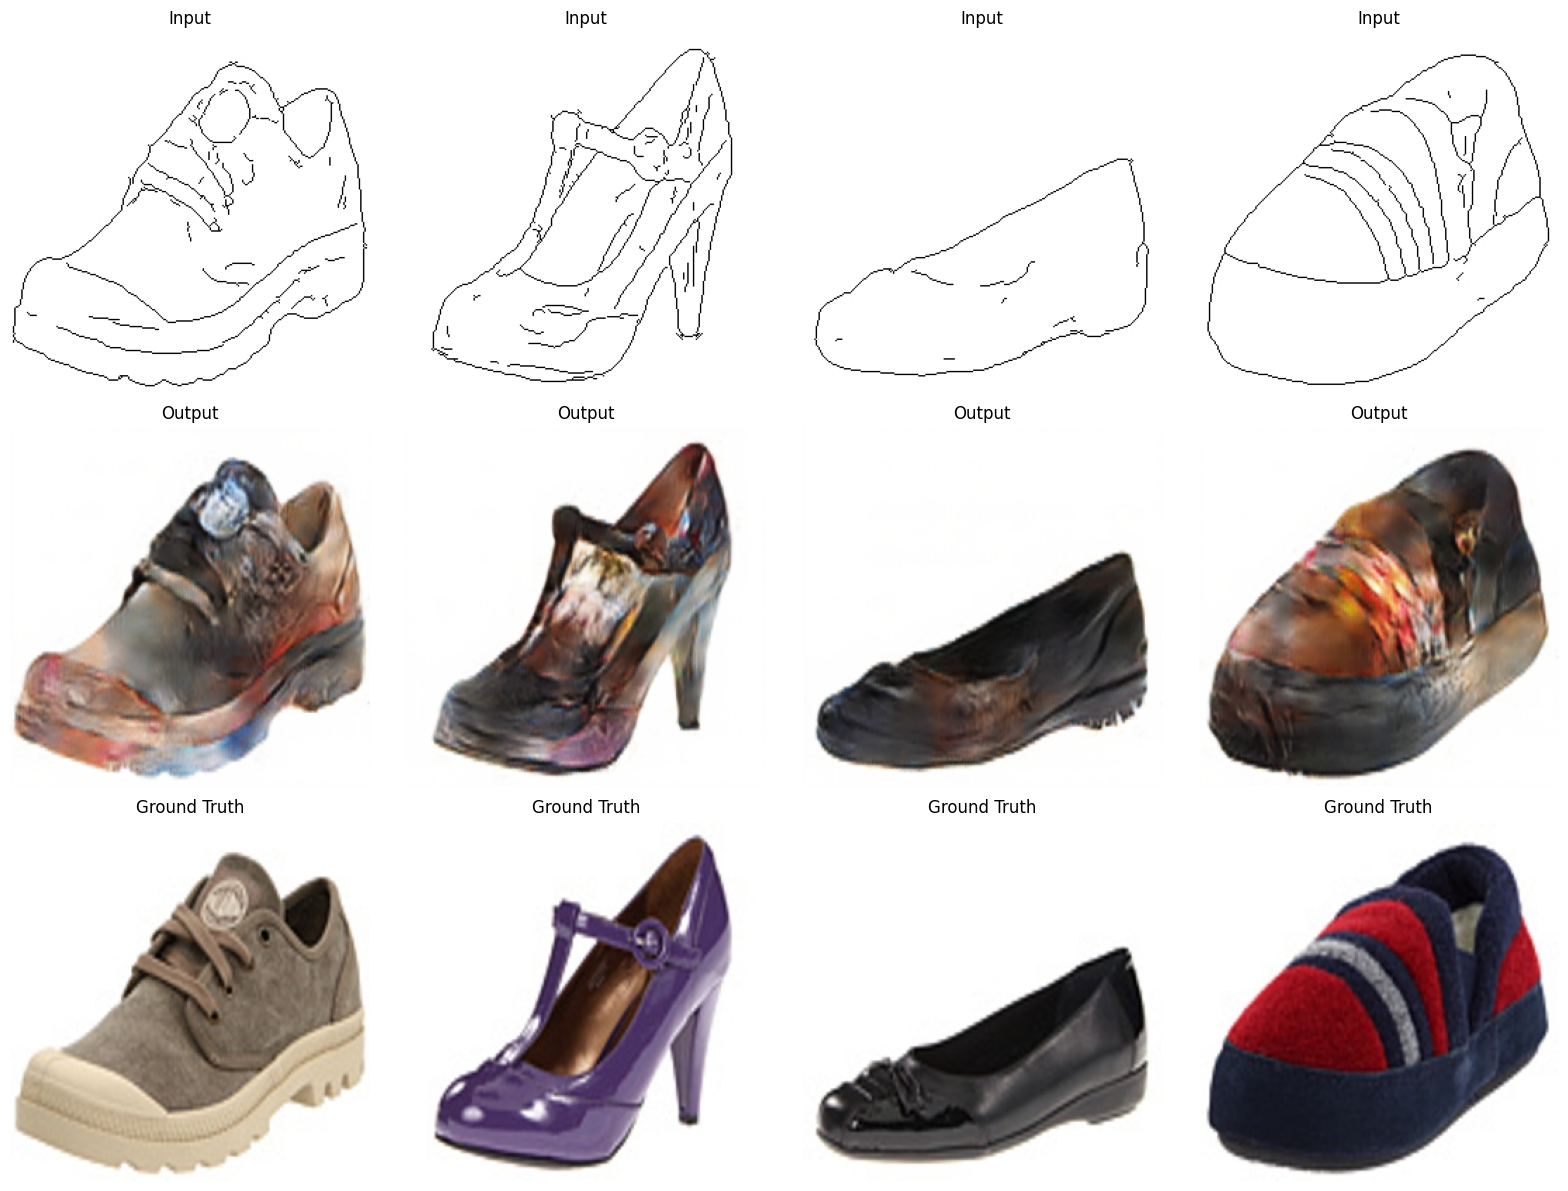

In [17]:
netG.eval()
with torch.no_grad():
    sample_edge, sample_shoe = next(iter(val_loader))
    sample_edge = sample_edge.to(device)
    fake_shoe = netG(sample_edge)
    
    sample_edge = sample_edge.cpu().detach()
    sample_shoe = sample_shoe.cpu().detach()
    fake_shoe = fake_shoe.cpu().detach()
    
    sample_edge = (sample_edge * 0.5 + 0.5).numpy()
    sample_shoe = (sample_shoe * 0.5 + 0.5).numpy()
    fake_shoe = (fake_shoe * 0.5 + 0.5).numpy()
    
    n = min(4, sample_edge.shape[0])
    plt.figure(figsize=(16, 12))
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(np.transpose(sample_edge[i], (1, 2, 0)))
        plt.title("Input")
        plt.axis("off")
        
        plt.subplot(3, n, i+1+n)
        plt.imshow(np.transpose(fake_shoe[i], (1, 2, 0)))
        plt.title("Output")
        plt.axis("off")
        
        plt.subplot(3, n, i+1+2*n)
        plt.imshow(np.transpose(sample_shoe[i], (1, 2, 0)))
        plt.title("Ground Truth")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()
